## Import des libs

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import zipfile

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Import des données

Pour commencer, nous devons spécifier quelques paramètres pour l'apprentissage:
<ul>
    <li>La longueur et la largeur des images. </li>
    <li>La taille du batch.</li>
</ul>

In [19]:
image_h = 150
image_w = 150
batch_s = 32

## Unzip

In [20]:
# repertoire = './'


dossier_dataset = './DatasetMulti'

# if not os.path.exists(dossier_dataset):
#     os.makedirs(dossier_dataset)

# for fichier in os.listdir(repertoire):
#    chemin_fichier = os.path.join(repertoire, fichier)

#    if zipfile.is_zipfile(chemin_fichier):
#         with zipfile.ZipFile(chemin_fichier, 'r') as zip_ref:
#            zip_ref.extractall(dossier_dataset)

In [21]:
dataset_folder = dossier_dataset
print("Début de la vérification des images avec TensorFlow...")
for subdir, _, files in os.walk(dataset_folder):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            img = tf.io.read_file(file_path)
            img = tf.image.decode_image(img)
        except Exception as e:
            print(f"Image {file_path} is invalid for TensorFlow. Exception: {e}")
            try:
                os.remove(file_path)
                print(f"Removed: {file_path}")
            except Exception as e_rm:
                print(f"Error removing {file_path}. Exception: {e_rm}")

print("Vérification des images terminée.")

Début de la vérification des images avec TensorFlow...


2023-10-10 07:38:35.369778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


Vérification des images terminée.


## Création des dataset

In [22]:
import tensorflow as tf

data_dir = dossier_dataset

train_set = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(image_h, image_w),
        batch_size=batch_s,
    )


test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
)


Found 41398 files belonging to 5 classes.
Using 33119 files for training.
Found 41398 files belonging to 5 classes.
Using 8279 files for validation.


## Visualisation des données

In [23]:
class_names = test_set.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


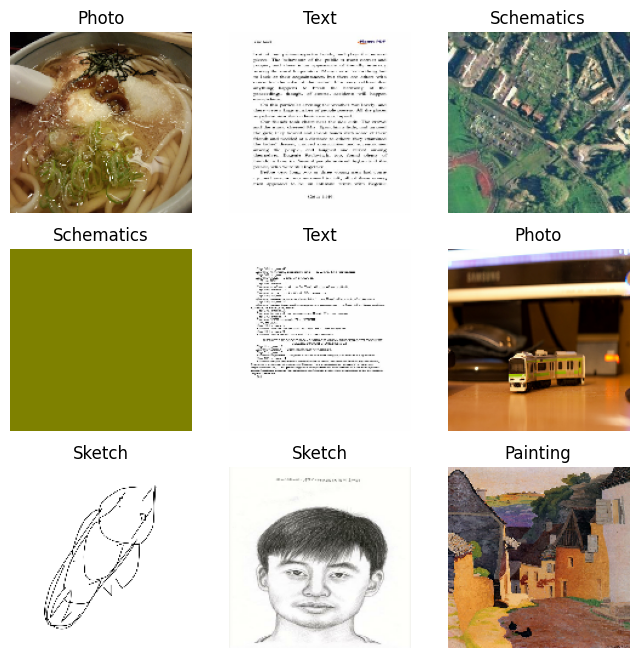

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax =  plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8')) 
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [25]:
print(type(train_set))
images, labels =  next(iter(train_set))
print(images.shape)
print(labels.shape)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
(32, 150, 150, 3)
(32,)


## Configuration de l'environnement pour l'entrainement

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [27]:
from keras.src.layers.preprocessing.image_preprocessing import HORIZONTAL_AND_VERTICAL
from keras.src.layers.preprocessing.image_preprocessing import RandomFlip
from keras.src.layers.preprocessing.image_preprocessing import RandomRotation
from keras.src.layers.preprocessing.image_preprocessing import RandomZoom
from keras import Sequential

data_augmentation = Sequential(
    [
        RandomFlip(
            mode=HORIZONTAL_AND_VERTICAL,
            input_shape=(image_h, image_w, 3)),
        RandomRotation(
            factor=0.18,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0),
        RandomZoom(
            height_factor=0.1,
            width_factor=None,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0)
    ]
)

## Création du modèle

In [28]:
num_classes = len(class_names)
epochs=20

In [29]:
model =  Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes) # 5 dans notre cas
])
model.build((None, image_h, image_w, 3))

## Compilation du modèle

In [30]:
model.compile(optimizer =  'adam',
                       loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                      

In [31]:
history =  model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)

Epoch 1/20


2023-10-10 07:41:13.351388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-10 07:41:23.476589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 161 of 1000
2023-10-10 07:41:43.533044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 483 of 1000
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
2023-10-10 07:42:03.490275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 804 of 1000
2023-10-10 07:42:17.585966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-10-10 07:42:17.680910: W tensorflow/core/lib/pn

ResourceExhaustedError: Graph execution error:

Detected at node Adam/StatefulPartitionedCall_6 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1046, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 736, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_8846/3832499062.py", line 1, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1783, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1130, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 544, in minimize

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 1340, in apply_grad_to_update_var

Out of memory while trying to allocate 368640260 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  703.12MiB
              constant allocation:         0B
        maybe_live_out allocation:  527.34MiB
     preallocated temp allocation:  351.56MiB
  preallocated temp fragmentation:       124B (0.00%)
                 total allocation:    1.03GiB
Peak buffers:
	Buffer 1:
		Size: 175.78MiB
		XLA Label: fusion
		Shape: f32[360000,128]
		==========================

	Buffer 2:
		Size: 175.78MiB
		XLA Label: fusion
		Shape: f32[360000,128]
		==========================

	Buffer 3:
		Size: 175.78MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[360000,128]
		==========================

	Buffer 4:
		Size: 175.78MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[360000,128]
		==========================

	Buffer 5:
		Size: 175.78MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[360000,128]
		==========================

	Buffer 6:
		Size: 175.78MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[360000,128]
		==========================

	Buffer 7:
		Size: 24B
		Operator: op_type="AssignSubVariableOp" op_name="AssignSubVariableOp" source_file="/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py" source_line=1161
		XLA Label: fusion
		Shape: (f32[360000,128], f32[360000,128], f32[360000,128])
		==========================

	Buffer 8:
		Size: 16B
		XLA Label: fusion
		Shape: (f32[360000,128], f32[360000,128])
		==========================

	Buffer 9:
		Size: 8B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: s64[]
		==========================

	Buffer 10:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow_1" source_file="/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py" source_line=1161
		XLA Label: fusion
		Shape: f32[]
		==========================

	Buffer 11:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow" source_file="/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py" source_line=1161
		XLA Label: fusion
		Shape: f32[]
		==========================

	Buffer 12:
		Size: 4B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[]
		==========================


	 [[{{node Adam/StatefulPartitionedCall_6}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_132713]